In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
image_dir = Path('../input/plantvillage-grape')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head()

Filepath  \
0  ../input/plantvillage-grape/grape/Grape/Grape_...   
1  ../input/plantvillage-grape/grape/Grape/Grape_...   
2  ../input/plantvillage-grape/Grape/Grape___Blac...   
3  ../input/plantvillage-grape/Grape/Grape___Blac...   
4  ../input/plantvillage-grape/grape/Grape/Grape_...   

                                        Label  
0  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  
1                           Grape___Black_rot  
2                           Grape___Black_rot  
3                           Grape___Black_rot  
4  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)

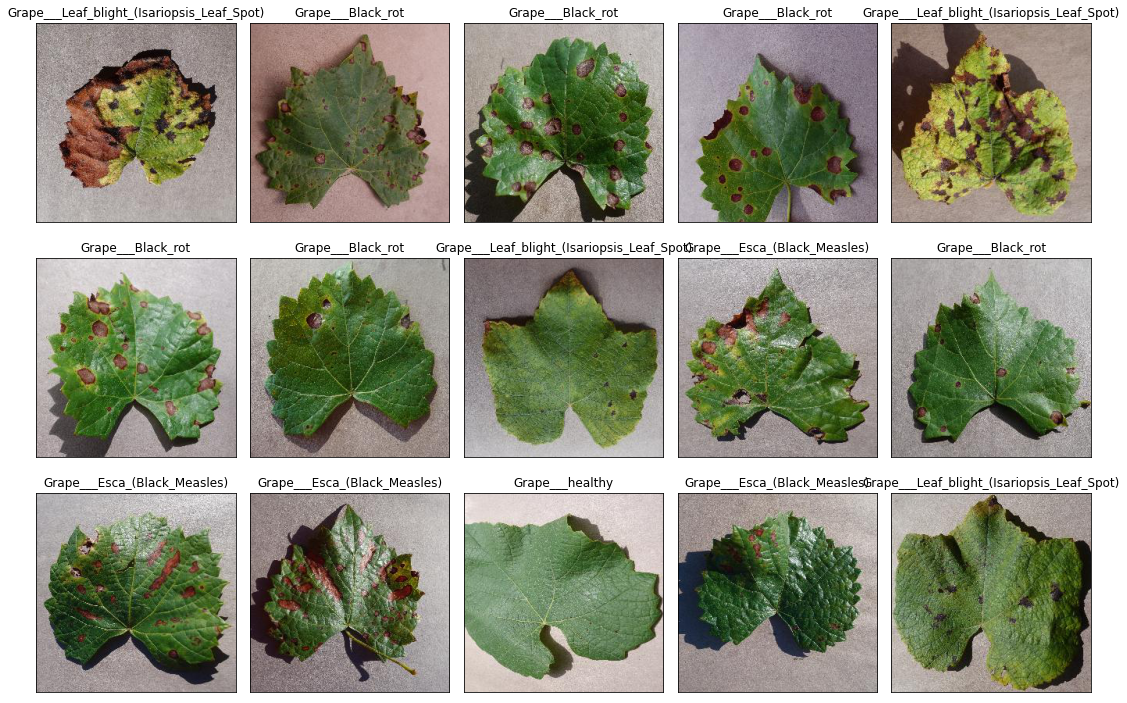

In [4]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [5]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [6]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

# Create the generators
train_generator,test_generator,train_images,val_images,test_images = create_gen()

Found 6580 validated image filenames belonging to 4 classes.
Found 731 validated image filenames belonging to 4 classes.
Found 813 validated image filenames belonging to 4 classes.


In [8]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
206/206 [==============================] - 24s 106ms/step - loss: 0.2823 - accuracy: 0.8823 - val_loss: 0.0304 - val_accuracy: 0.9918
Epoch 2/10
206/206 [==============================] - 21s 100ms/step - loss: 0.0414 - accuracy: 0.9874 - val_loss: 0.0303 - val_accuracy: 0.9877
Epoch 3/10
206/206 [==============================] - 21s 100ms/step - loss: 0.0195 - accuracy: 0.9919 - val_loss: 0.0083 - val_accuracy: 0.9959
Epoch 4/10
206/206 [==============================] - 21s 102ms/step - loss: 0.0187 - accuracy: 0.9928 - val_loss: 0.0042 - val_accuracy: 0.9986
Epoch 5/10
206/206 [==============================] - 21s 101ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0042 - val_accuracy: 0.9986
Epoch 6/10
206/206 [==============================] - 20s 99ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9986


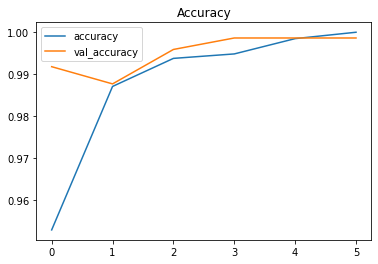

In [14]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

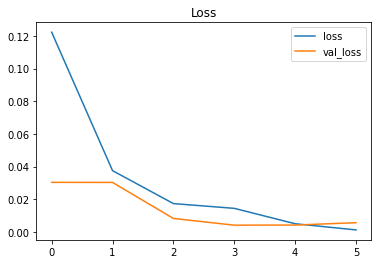

In [15]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [17]:
results = model.evaluate(test_images, verbose=0)

In [18]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.00986

## Accuracy on the test set: 99.75%

In [19]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Grape___healthy', 'Grape___Esca_(Black_Measles)', 'Grape___Black_rot', 'Grape___healthy', 'Grape___Black_rot']


In [20]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.99      1.00      1.00       240
              Grape___Esca_(Black_Measles)       1.00      0.99      1.00       276
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00       201
                           Grape___healthy       1.00      1.00      1.00        96

                                  accuracy                           1.00       813
                                 macro avg       1.00      1.00      1.00       813
                              weighted avg       1.00      1.00      1.00       813



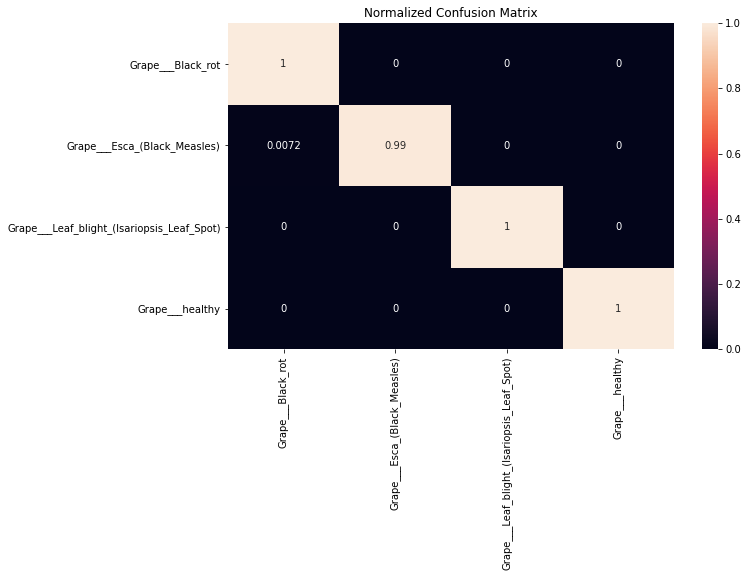

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

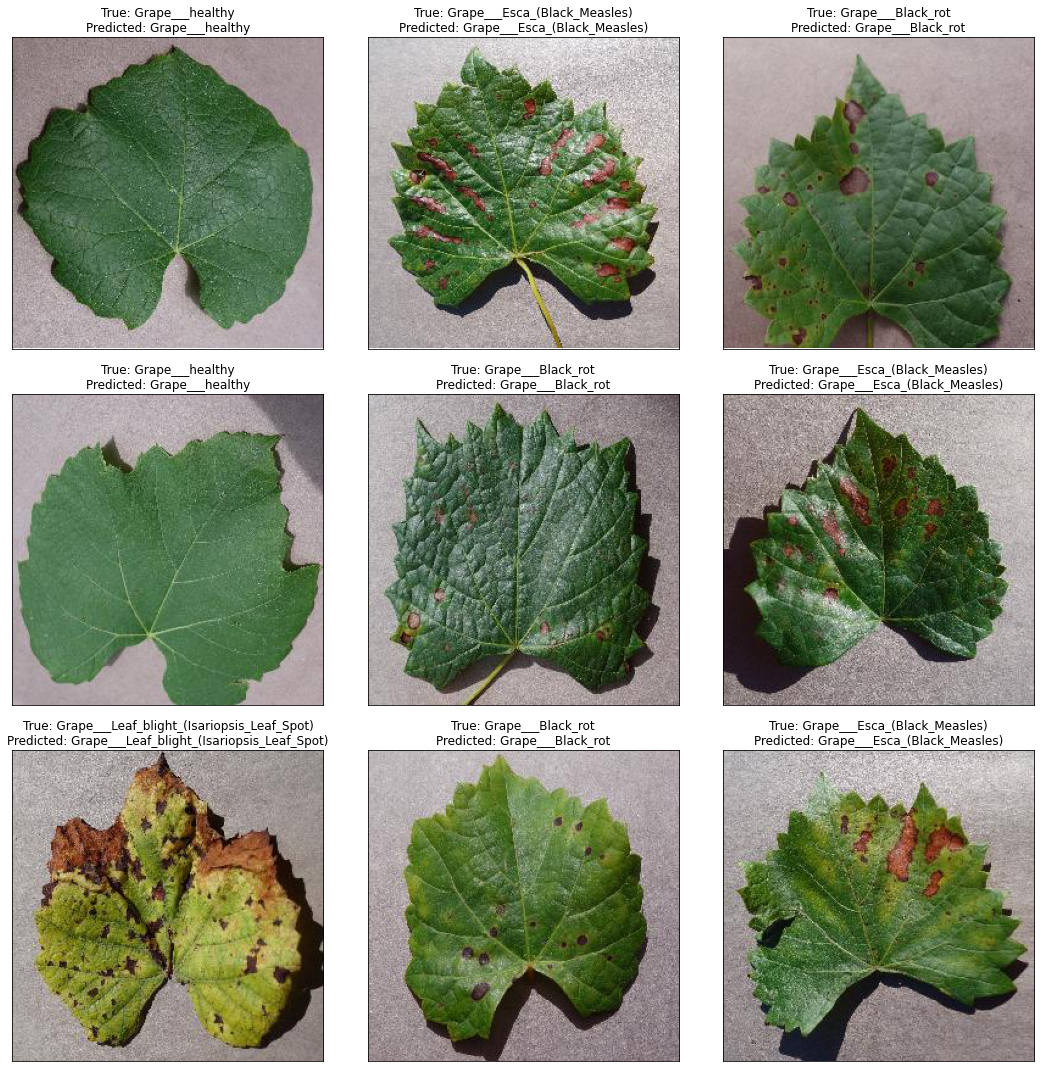

In [22]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [23]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

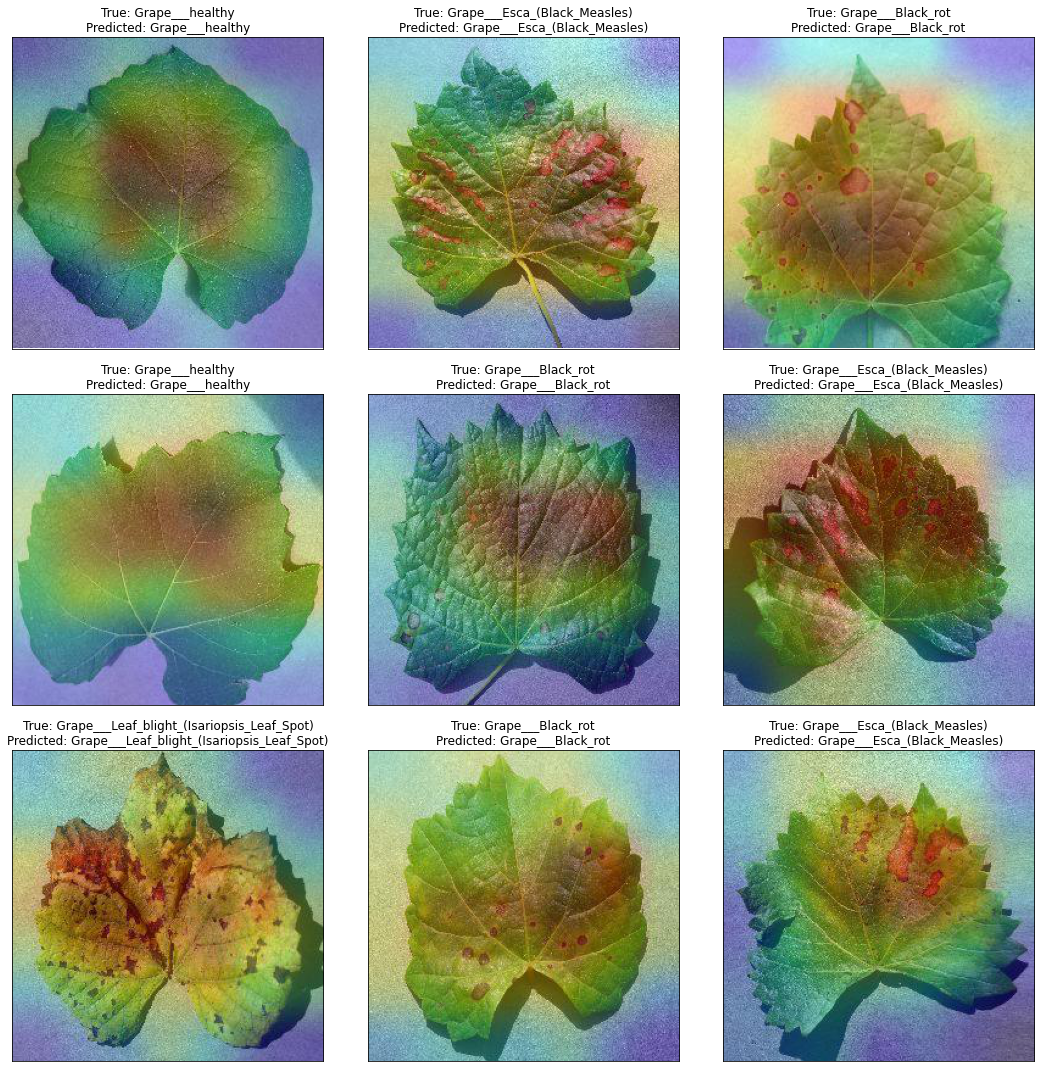

In [24]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()